#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [2]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [ ]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



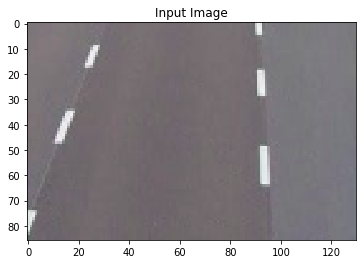

The starting and end points (x,y) of the detected lines are :  
 1.(0,83)--->(25,9)
 2.(92,0)--->(95,64)
 3.(1,81)--->(27,9)
 4.(90,0)--->(92,63)


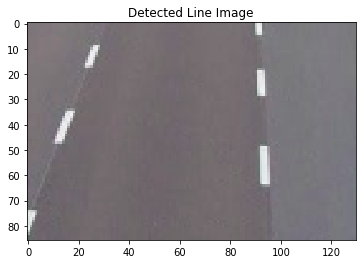

In [8]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####

lines = cv2.HoughLinesP(edges,1,np.pi/180,15,minLineLength = 60,maxLineGap = 250)
N = lines.shape[0]

print('The starting and end points (x,y) of the detected lines are :  ')
for i in range(N):
    x1 = lines[i][0][0]
    y1 = lines[i][0][1]    
    x2 = lines[i][0][2]
    y2 = lines[i][0][3]
    
    print(' %d.(%d,%d)--->(%d,%d)'%(i+1,x1,y1,x2,y2))
#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [11]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(num_points*out_rate)
        inliers = num_points - outliers
        
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = A@points_s[:,:inliers] + t
        
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        
        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####
        [[[x1],[x2],[x3]],[[y1],[y2],[y3]]] = points_s
        [[[x1_t],[x2_t],[x3_t]],[[y1_t],[y2_t],[y3_t]]] = points_t
        
        M = np.array([[x1,y1,0,0,1,0],
              [0,0,x1,y1,0,1],
              [x2,y2,0,0,1,0],
              [0,0,x2,y2,0,1],
             [x3,y3,0,0,1,0],
             [0,0,x3,y3,0,1]])
        
        b = np.array([[x1_t,y1_t,x2_t,y2_t,x3_t,y3_t]]).T
        
        theta = np.linalg.pinv(M)@b
        
        A = np.array([[theta[0],theta[1]],[theta[2],theta[3]]])
        t = np.array([[theta[4]],[theta[5]]])

        A = A.reshape((2,2))
        t = t.reshape((2,1))
            
        return A,t

        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000

class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr
        
        
    
    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE
        points_t_cap = A@points_s + t
        diff = points_t - points_t_cap
        
        
        residual = np.linalg.norm(diff,axis = 0)
        return residual
        

        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimateda ffine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        max_inliers = 0
        A_opt = np.zeros((2,2))
        t_opt = np.zeros((2,1))
        
        for i in range(ITER_NUM):
            idx = np.random.randint(0, points_s.shape[1], (self.L, 1))
            A_temp, t_temp = tf.affine_transformation(points_s[:, idx], points_t[:, idx])
            r_temp = self.calculate_distance(A_temp,t_temp,points_s,points_t)
            inliers = (r_temp <= self.thr*np.ones(r_temp.shape) )
            inlier_count = np.count_nonzero(inliers == True)
            
            if(inlier_count > max_inliers):
                A_opt = A_temp
                t_opt = t_temp
                inliers_opt = inliers
                max_inliers = inlier_count
                
        inlier_indices = np.matrix([i for i, val in enumerate(inliers_opt) if val])

        return A_opt,t_opt,inlier_indices

        
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers[0].shape)


(1, 101)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



The no. of detected corner pixels before dilation :  62
The no. of detected corner pixels after dilation :  222


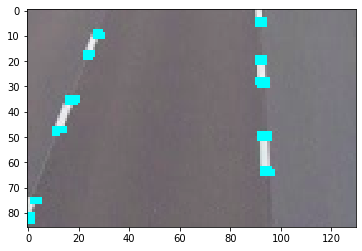

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image_copy,cv2.COLOR_RGB2GRAY)
## STEP 2: Detect corners 
corners = cv2.cornerHarris(gray,2,3,0.04)

print('The no. of detected corner pixels before dilation : ',image[corners > 0.1*corners.max()].shape[0])

## STEP 3: Dilate corner image to enhance corner points
dilated = cv2.dilate(corners,None)
## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
image[dilated > 0.1*dilated.max()] = [0,255,255]


## STEP 5: Count numer of detected corner points and draw them on the image
print('The no. of detected corner pixels after dilation : ',image[dilated > 0.1*dilated.max()].shape[0])
plt.imshow(image,cmap = 'gray')
plt.show()
### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [3]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"   


device = torch.device(dev)

# define a transforms for preparing the dataset
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307),(0.3081))])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

In [4]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset =  datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
#### YOUR CODE ENDS HERE ####

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=True)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16,kernel_size = 3,stride = 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32,kernel_size = 3,stride = 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64,kernel_size = 3,stride = 1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)  ### stride defaualt is kernel size
        # define dropout layer with a probability of 0.25
        self.drop1= nn.Dropout(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2= nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear( 128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.pool(self.conv3(x)))
        x = self.drop1(x)
        x = x.view(-1,64*11*11)
        x = self.drop2(F.relu(self.fc1(x)))
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [6]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 10.023s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0                                                      ### Self added
    iter = 0                                                            ### Self added
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target = data.to(device),target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model.forward(data)
        # calculate the loss (use nll_loss in pytorch)
        criterion = nn.NLLLoss()
        loss = criterion(output,target)
        total_loss +=loss.item()
        iter = iter +1
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    avg_loss = total_loss/iter                                            ### Self added
    return avg_loss

In [9]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target = data.to(device),target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model.forward(data)
            criterion = nn.NLLLoss()
            loss = criterion(output,target)
            test_loss += loss # sum up batch loss
            _,pred = torch.max(output.data,1)
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    accuracy = float (100.* correct / len(test_loader.dataset)) ### self added
    
    return test_loss,accuracy

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298314
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.523098
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.526823
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.535756
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.526515
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.362945
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.119567
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.442963
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.352064
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.060798
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.426546
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.070544
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.155194
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.422950
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.109918
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.313892
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.386078
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.159274
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.356118
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.290959
Train Epoch: 0 [12800/60000 (

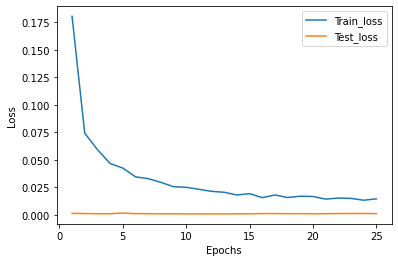

Train Accuracy: 99.96333333333334
Test Accuracy: 99.27


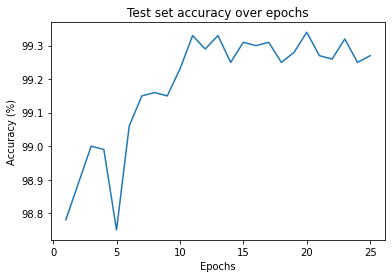

In [ ]:
import time 
import matplotlib.pyplot as plt

net = Net().to(device)                               ##### TO 
optimizer = optim.Adam(net.parameters())             ##### TO 
total_epochs = 25

train_loss_vec = np.zeros(total_epochs)
test_loss_vec = np.zeros(total_epochs)
test_accuracy = np.zeros(total_epochs)

#starting time 
begin = time.time() 
  
for epoch in range(total_epochs):
    train_loss_vec[epoch] = train(net, device, train_dataloader, optimizer, epoch)   #### TO
    test_loss_vec[epoch],test_accuracy[epoch]  = test(net, device, test_dataloader)  #### TO

end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}")   


###########################################   Plots and 
e = np.arange(1,26)
plt.plot(e,train_loss_vec)
plt.plot(e,test_loss_vec)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train_loss','Test_loss'])
plt.show()

plt.plot(e,test_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test set accuracy over epochs')
#Total runtime of the program is 378.68857741355896

### Accuracy of the train set and test set after training : 
# Train Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in train_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net.forward(images)                           ############ TO
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Train Accuracy: {100*(correct/total)}")

# Test Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net.forward(images)                         ############## TO
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100*(correct/total)}")


# Q4. Observations 

The above is the plot for losses over epochs :
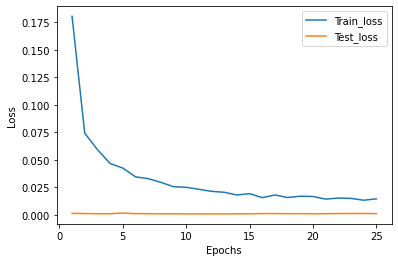 



Total time taken for training : 680 secs ~ 11 mins

After training for 25 epochs, the model yields : 

Train_set Accuracy: 99.96 %

Test_set Accuracy: 99.27 %

### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

In [ ]:
#### Using Sigmoid activation : 


class Sig_Net(nn.Module):
    def __init__(self):
        super(Sig_Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16,kernel_size = 3,stride = 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32,kernel_size = 3,stride = 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64,kernel_size = 3,stride = 1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)  ### stride defaualt is kernel size
        # define dropout layer with a probability of 0.25
        self.drop1= nn.Dropout(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2= nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear( 128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = torch.sigmoid(self.pool(self.conv3(x)))
        x = self.drop1(x)
        x = x.view(-1,64*11*11)
        x = self.drop2(torch.sigmoid(self.fc1(x)))
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [ ]:
import time 
sig_net = Sig_Net().to(device)
optimizer = optim.Adam(sig_net.parameters())
total_epochs = 25

#starting time 
begin = time.time() 

for epoch in range(total_epochs):
  train(sig_net, device, train_dataloader, optimizer, epoch)
  test(sig_net, device, test_dataloader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.279878
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.413082
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.432150
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.411301
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.324282
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.241952
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.341058
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.472695
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.355520
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.253894
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.357950
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.355861
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.272628
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.347426
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.351605
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.374987
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.344025
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.299083
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.350894
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.326496
Train Epoch: 0 [12800/60000 (

In [ ]:
# Train Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in train_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = sig_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Train Accuracy: {100*(correct/total)}")

# Test Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = sig_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100*(correct/total)}")


Train Accuracy: 9.915000000000001
Test Accuracy: 10.09


# Q5 Observations

After replacing the ReLu activations with Sigmoids, we can observe that the model performs very poorly.

Yes, the accuracy falls  close to 10%

Train Accuracy: 9.91

Test Accuracy: 10.09

It yields a test accuracy of 10% for every epoch of training. And losses remain the same throughout the training , which hints us that the model is not "learning"

This is a consequence of the vanishing gradient problem caused by using sigmoid activation.


We know that the derivative of sigmoid function lies between [0,1] .


Gradients of nueral nets are computed using back propagation,  which uses chain rule.  For computing the gradients of initial layers , the derivatives are multiplied down the net (from the final to the initial).

Hence when the gradient is between [0,1]; the product of gradient decreases exponentially. Hence gradient for the initial layer will be too small for an effective training.

When the initial layers are not able to train , the whole network falls behind , since the subsequent layers depend on the output of initial layers. This becomes a chicken and egg problem, which leads to bad training.

This can be tackled by Relu activation which need not have <1 derivative.

### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [ ]:
import time 
SGD_net = Net().to(device)
optimizer = optim.SGD(SGD_net.parameters(),lr = 0.001)
total_epochs = 25

#starting time 
begin = time.time() 

for epoch in range(total_epochs):
  train(SGD_net, device, train_dataloader, optimizer, epoch)
  test(SGD_net, device, test_dataloader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.293950
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.310970
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.312917
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.288923
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.310022
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.314132
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.287567
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.294826
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.312794
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.309434
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.289385
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.299410
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.283494
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.267854
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.284017
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.269230
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.283324
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.277239
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.285295
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.267300
Train Epoch: 0 [12800/60000 (

# Q6 Observations
I used a SGD optimizer with a learning rate of 0.001 with no mentioned "momentum" parameter.

It yields a test-accuracy of 97.85 % at the end of 25 epochs.

We can observe that the training is  slower when compared to Adam optimizer, meanining learning per epoch is slow. It is also suffering from converging.

SGD learns using a constant learning rate , which makes it slower and prone to oscillations while training. Its because it takes the same step , and thus becomes more unstable at sharp minimas.

While Adam is an adaptive optimiser, which adjusts the learning rate  timely depending on the recent trend of gradients.


### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [ ]:
class INIT_Net(nn.Module):
    def __init__(self):
        super(INIT_Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16,kernel_size = 3,stride = 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32,kernel_size = 3,stride = 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64,kernel_size = 3,stride = 1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)  ### stride defaualt is kernel size
        # define dropout layer with a probability of 0.25
        self.drop1= nn.Dropout(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2= nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear( 128, 10)

        self.init_weights()
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.pool(self.conv3(x)))
        x = self.drop1(x)
        x = x.view(-1,64*11*11)
        x = self.drop2(F.relu(self.fc1(x)))
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output


    def init_weights(self):
      for m in self.modules():
        if isinstance(m,nn.Conv2d):
          nn.init.constant(m.weight,1)
          if m.bias is not None:
            nn.init.constant(m.bias,1)

In [ ]:
import time
pre_init_net = INIT_Net().to(device)
optimizer = optim.Adam(pre_init_net.parameters())

total_epochs = 25
#starting time 
begin = time.time() 

for epoch in range(total_epochs):
  train(pre_init_net,device,train_dataloader,optimizer,epoch)
  test(pre_init_net,device,test_dataloader)

end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}")   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


Train Epoch: 0 [0/60000 (0%)]	Loss: 244628.875000
Train Epoch: 0 [640/60000 (1%)]	Loss: 6859.169434
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.219861
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.306310
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.231326
Train Epoch: 0 [3200/60000 (5%)]	Loss: 18.653595
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.294458
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.225508
Train Epoch: 0 [5120/60000 (9%)]	Loss: 50.706097
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.306649
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.301598
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.303262
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.313064
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.309117
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.296890
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.308620
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.303433
Train Epoch: 0 [10880/60000 (18%)]	Loss: 107.846695
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.300974
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.302428
Train Epoch: 0 [1

# Q7 Observations : 

By initialsing the weights and bias as 1, we can see that the model performs very poorly.

After 25 epochs of training the model yields a 

Test_set accuracy of 11.35 %

When all the wieghts and bias are initialsed as  constants, the outputs of all hidden units will be similar. Thus all the nodes in a layer has same influence on the loss function, which leads to similar gradients , thus again same weights.

This will prevent the different nuerons to learn different things , which is key for better performance,



### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [6]:
class Xavier_INIT_Net(nn.Module):
    def __init__(self):
        super(Xavier_INIT_Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16,kernel_size = 3,stride = 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32,kernel_size = 3,stride = 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64,kernel_size = 3,stride = 1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)  ### stride defaualt is kernel size
        # define dropout layer with a probability of 0.25
        self.drop1= nn.Dropout(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2= nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear( 128, 10)

        self.init_weights()
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.pool(self.conv3(x)))
        x = self.drop1(x)
        x = x.view(-1,64*11*11)
        x = self.drop2(F.relu(self.fc1(x)))
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

    def init_weights(self):
      for m in self.modules():
        if isinstance(m,nn.Conv2d):
          nn.init.xavier_normal(m.weight )
          if m.bias is not None:
            nn.init.constant(m.bias,0)

        if isinstance(m,nn.Linear):
          nn.init.xavier_normal(m.weight)
          if m.bias is not None:
            nn.init.constant(m.bias,0)


In [14]:
import time
xav_init_net = Xavier_INIT_Net().to(device)
optimizer = optim.Adam(xav_init_net.parameters())

total_epochs = 25
#starting time 
begin = time.time() 

for epoch in range(total_epochs):
  train(xav_init_net,device,train_dataloader,optimizer,epoch)
  test(xav_init_net,device,test_dataloader)

end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}")   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.354566
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.939151
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.415648
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.370748
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.391424
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.773953
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.207065
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.198739
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.145313
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.517044
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.545455
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.249637
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.168610
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.173761
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.538797
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.156705
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.254651
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.324457
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.071770
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.069226
Train Epoch: 0 [12800/60000 (

# Q8 Observations
Unlike the former pre initialised methods, xaviers init works very well.

It yeilds a test accuracy of : 99.41 %

This is because it initialises the weights from a uniform distribution based upon the no.of incoming and outgoing connections.


Thus this random initialisation of weights enables different nuerons learn different aspects, and makes the model more diverse thus it works very better. 

It also converges very fast.

### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [ ]:
class Batch_Net(nn.Module):
    def __init__(self):
        super(Batch_Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16,kernel_size = 3,stride = 1)
        self.bn_1 = nn.BatchNorm2d(16)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32,kernel_size = 3,stride = 1)
        self.bn_2 = nn.BatchNorm2d(32)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64,kernel_size = 3,stride = 1)
        self.bn_3 = nn.BatchNorm2d(64)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)  ### stride defaualt is kernel size
        # define dropout layer with a probability of 0.25
        self.drop1= nn.Dropout(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2= nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear( 128, 10)

        
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = F.relu( self.bn_1(self.conv1(x)) )
        x = F.relu(self.bn_2 (self.conv2(x)) )
        x = F.relu( self.pool(self.bn_3 (self.conv3(x)) ) ) 
        x = self.drop1(x)
        x = x.view(-1,64*11*11)
        x = self.drop2(F.relu(self.fc1(x)))
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [ ]:
import time
batch_net = Batch_Net().to(device)
optimizer = optim.Adam(batch_net.parameters())

total_epochs = 25
#starting time 
begin = time.time() 

for epoch in range(total_epochs):
  train(batch_net,device,train_dataloader,optimizer,epoch)
  test(batch_net,device,test_dataloader)

end = time.time() 
# total time taken 
print(f"Total runtime of the program is {end - begin}")   

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.449089
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.902598
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.858544
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.594675
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.423375
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.292768
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.439687
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.150342
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.372341
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.435827
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.400338
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.275670
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.081485
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.280141
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.710659
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.189227
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.156259
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.124623
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.217916
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.234121
Train Epoch: 0 [12800/60000 (

In [ ]:
# Train Accuracy with batch  norm...
correct = 0
total = 0
with torch.no_grad():
    for data in train_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = batch_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Train Accuracy: {100*(correct/total)}")

# Test Accuracy with batch norm
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = batch_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100*(correct/total)}")


Train Accuracy: 99.955
Test Accuracy: 99.33999999999999


# Q9 Observations

After training of 25 epochs , the model with added batch norm yields : 

Train Accuracy: 99.955

Test Accuracy: 99.33999999999999

Batch norm helps us learn faster. It allows to have a high learning rate (although it is unimportant here , since we are using Adam optimizer which adaptively changes lr.)

We can also observe local stability of losses while learning. This holds true since Batch Norm acts as a weight regulizer, since all the inputs will have similar statistics.

# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
